<h2 style="color:#DE3163">Breast Cancer Dedection Using CNN</h2>

![Alt Text](https://www.pdcenterlv.com/wp-content/uploads/2023/11/Why-Is-Early-Detection-of-Breast-Cancer-Important-1.jpg)

<h2 style="color:#DE3163">Introduction</h2>

This notebook how deep learning methods, particularly convolutional neural networks (CNNs), can be leveraged to improve the accuracy of breast cancer diagnosis using histopathological images. By optimizing these techniques, we aim to enable earlier detection and minimize the devastating impact of this disease.
Accurate and early diagnosis of breast cancer can significantly improve patient outcomes and reduce the physical and mental toll of the disease.
Globally, breast cancer claims the lives of 670,000 people annually and affects 2.3 million women, underscoring the urgent need for enhanced diagnostic tools.


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
import PIL
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Rescaling
import glob
import cv2

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l2
import itertools

<h2 style="color:#DE3163">Loading Data</h2>

In [2]:
# Create the dataset
dataset = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png',recursive = True)


In [3]:
for img in dataset[:3]:
    print(img)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


In [4]:
## The number of images we have

len(dataset)    

277524

In [5]:
# The number of patients
# Folder counts show the number of patients

basepath = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder_count = os.listdir(basepath)
len(folder_count) 

279


<h2 style="color:#DE3163">Visualization</h2>

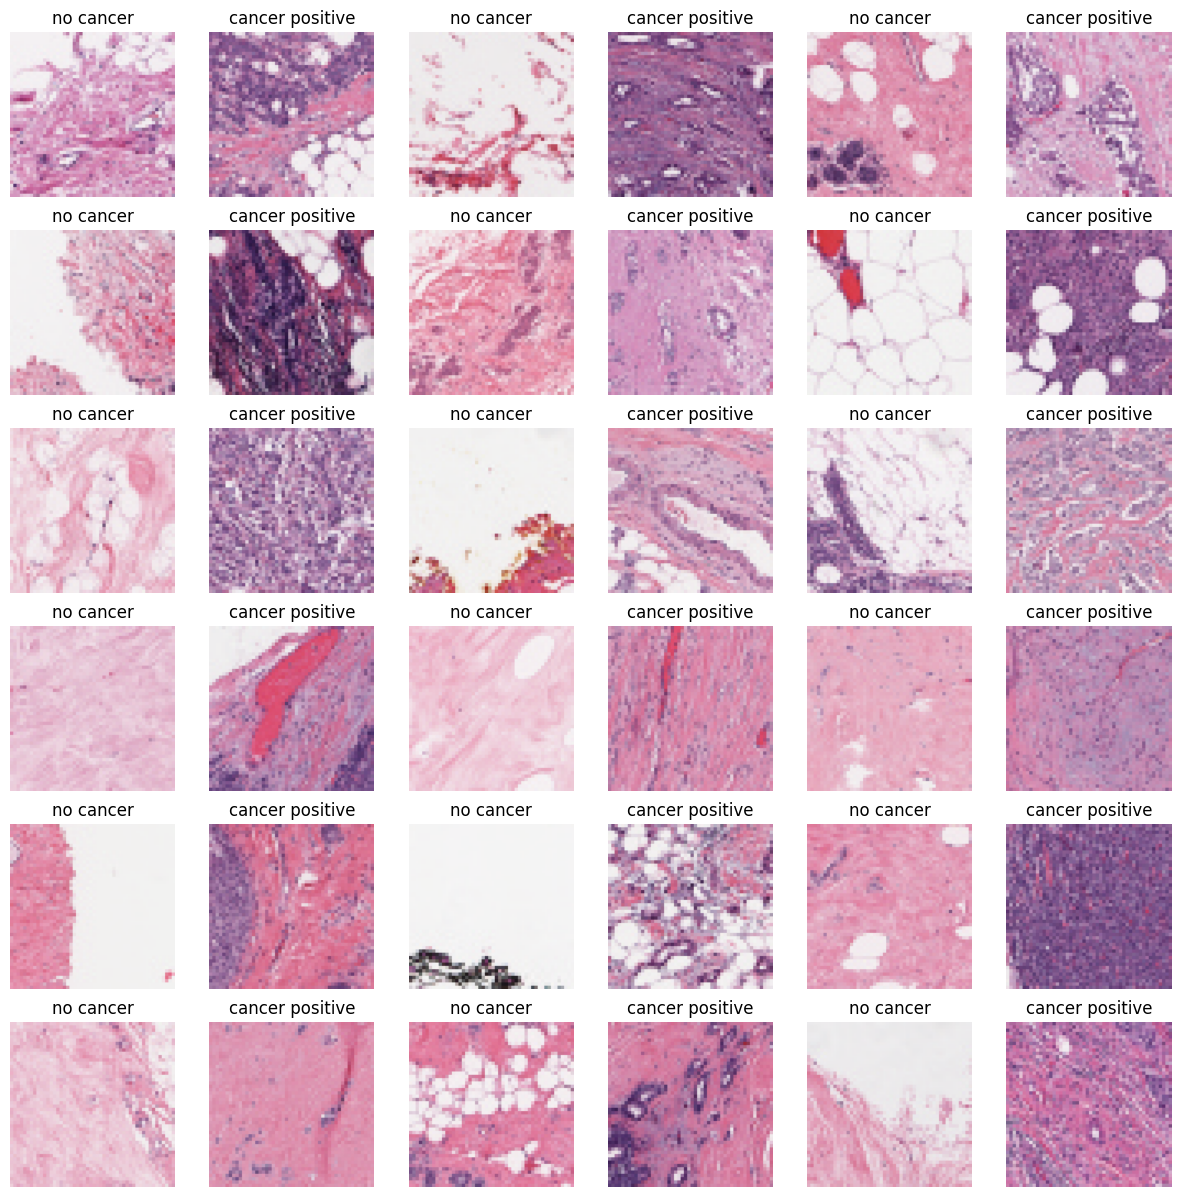

In [6]:
negative_idc = []
positive_idc = []

for img in dataset:
    if img[-5] == '0' :
        negative_idc.append(img)
    
    elif img[-5] == '1' :
        positive_idc.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(negative_idc), 18)
some_can = np.random.randint(0, len(positive_idc), 18)

s = 0
for num in some_non:
    
        img = image.load_img((negative_idc[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((positive_idc[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('cancer positive')
        plt.imshow(img.astype('uint8'))
        s += 1


In [7]:

print(len(negative_idc))
print(len(positive_idc))

198738
78786


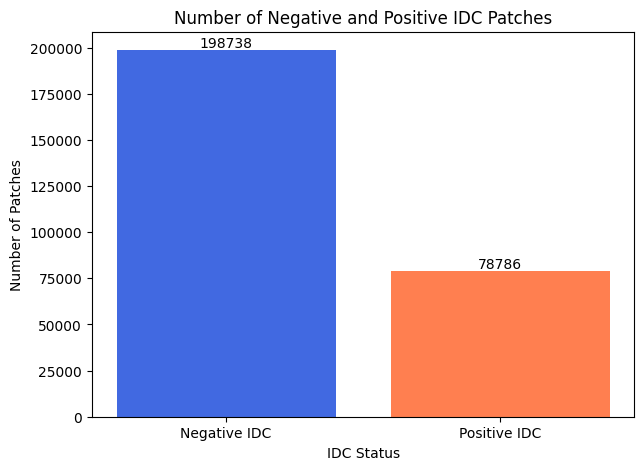

In [8]:
## Categories positive idc or negative idc

num_negative_idc = len(negative_idc)
num_positive_idc = len(positive_idc)


categories = ['Negative IDC', 'Positive IDC']
counts = [num_negative_idc, num_positive_idc]

# Graph
fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(categories, counts, color=['RoyalBlue', 'coral'])


for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, 
            f'{height}', ha='center', va='bottom')

ax.set_xlabel('IDC Status')
ax.set_ylabel('Number of Patches')
ax.set_title('Number of Negative and Positive IDC Patches')

plt.show()

Since the number of negative idc are more than the number of positive idc shows us imbalanced class problem. This needs to be solved before modelling. 

<h2 style="color:#DE3163">Under-Sampling</h2>

In [9]:
## Under-Sampling
## Keeping X and y separate and under-sampling. 
## The number of images are decreased from 277542 to 40057.

total = len(negative_idc) + len(positive_idc)
ppos = len(positive_idc)/total
desired = 40000
psamp = desired/total
print(total, ppos, desired, psamp)

non_img_arr = []
can_img_arr = []
non_y = []
can_y = []

for i,img in enumerate(negative_idc):
    if (np.random.uniform() < psamp):
      n_img = cv2.imread(img, cv2.IMREAD_COLOR)
      n_img = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      non_img_arr.append(n_img)
      non_y.append(0)

for i,img in enumerate(positive_idc):
    if (np.random.uniform() < psamp):
      c_img = cv2.imread(img, cv2.IMREAD_COLOR)
      c_img = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
      can_img_arr.append(c_img)
      can_y.append(1)

X = np.concatenate((non_img_arr, can_img_arr))
y = np.concatenate([non_y,can_y])

277524 0.28388896095472826 40000 0.14413167870166183


In [10]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 40142
Number of IDC(-) Images: 28807
Number of IDC(+) Images: 11335
Image shape (Width, Height, Channels): (50, 50, 3)


<h2 style="color:#DE3163">Train and Test Splitting</h2>

In [11]:
## Train-Test Splitting 

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (28099, 50, 50, 3)
Testing Data Shape: (12043, 50, 50, 3)


<h2 style="color:#DE3163">Modelling</h2>

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5) #Early Stopping

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            5

 Total params: 2,514,410 (9.59 MB)

 Trainable params: 2,513,642 (9.59 MB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
# Model Training

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=35)

Epoch 1/10


2024-08-06 20:52:24.553385: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 2.36257, expected 2.02498
2024-08-06 20:52:24.553476: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5000: 4.71043, expected 4.10257
2024-08-06 20:52:24.553494: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5012: 4.829, expected 4.22113
2024-08-06 20:52:24.553522: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5016: 4.8818, expected 4.27393
2024-08-06 20:52:24.553534: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5030: 4.47237, expected 3.8645
2024-08-06 20:52:24.553544: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5031: 4.71155, expected 4.10368
2024-08-06 20:52:24.553555: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5042: 4.68974, expected 4.08187
2024-08-06 20:52:24.553565: E external/l

 21/803 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4124 - loss: 6.7290 

I0000 00:00:1722977551.296999     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


799/803 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7313 - loss: 5.5984

2024-08-06 20:52:39.746382: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2500: 3.48052, expected 2.94052
2024-08-06 20:52:39.746441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2506: 3.78776, expected 3.24776
2024-08-06 20:52:39.746450: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2507: 4.12391, expected 3.58391
2024-08-06 20:52:39.746458: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2508: 4.27061, expected 3.73061
2024-08-06 20:52:39.746466: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2509: 4.14175, expected 3.60175
2024-08-06 20:52:39.746474: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2510: 4.33599, expected 3.796
2024-08-06 20:52:39.746482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2512: 3.48556, expected 2.94556
2024-08-06 20:52:39.746490: E extern

803/803 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.7318 - loss: 5.5934 - val_accuracy: 0.8054 - val_loss: 3.4642
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8349 - loss: 2.8967 - val_accuracy: 0.7928 - val_loss: 1.8827
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8374 - loss: 1.5909 - val_accuracy: 0.8131 - val_loss: 1.2154
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8444 - loss: 1.0045 - val_accuracy: 0.8294 - val_loss: 0.7974
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8498 - loss: 0.7362 - val_accuracy: 0.8328 - val_loss: 0.6404
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8519 - loss: 0.5850 - val_accuracy: 0.8291 - val_loss: 0.5503
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8485 - loss: 0.5152 - val_accuracy: 0.8377 - val_loss: 0.5069
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8502 - loss: 0.4667 - val_accuracy: 0.8533 - va

<h2 style="color:#DE3163">Model Evaluation</h2>

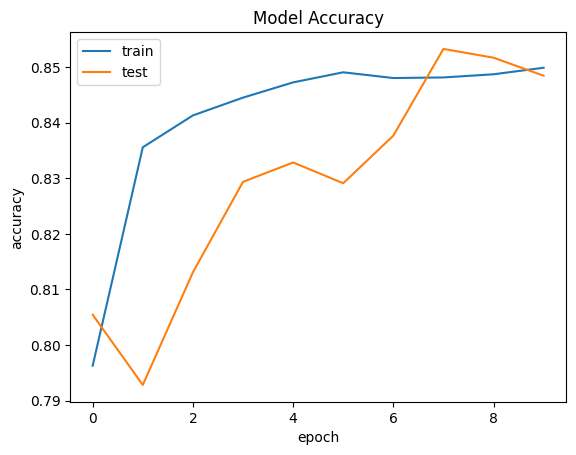

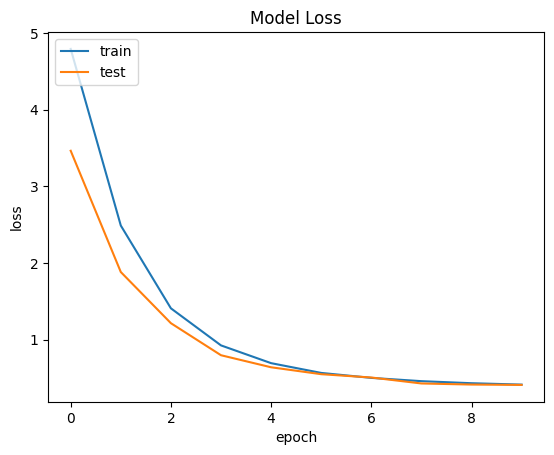

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2024-08-06 20:53:54.944331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.81553, expected 3.27557
2024-08-06 20:53:54.944387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 4.21476, expected 3.6748
2024-08-06 20:53:54.944402: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18: 4.09888, expected 3.55892
2024-08-06 20:53:54.944419: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19: 4.25953, expected 3.71957
2024-08-06 20:53:54.944434: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 24: 4.29306, expected 3.7531
2024-08-06 20:53:54.944445: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 25: 3.92733, expected 3.38737
2024-08-06 20:53:54.944457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 3.7289, expected 3.18894
2024-08-06 20:53:54.944468: E external/local_xla/xla

359/377 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2024-08-06 20:53:56.803044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2549: 3.1994, expected 2.75475
2024-08-06 20:53:56.803110: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4981: 3.1049, expected 2.66025
2024-08-06 20:53:56.803120: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5000: 4.00847, expected 3.04242
2024-08-06 20:53:56.803129: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5001: 6.82812, expected 5.86207
2024-08-06 20:53:56.803136: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5002: 6.18477, expected 5.21872
2024-08-06 20:53:56.803144: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5003: 7.07008, expected 6.10402
2024-08-06 20:53:56.803152: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5004: 6.35705, expected 5.391
2024-08-06 20:53:56.803160: E external

377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


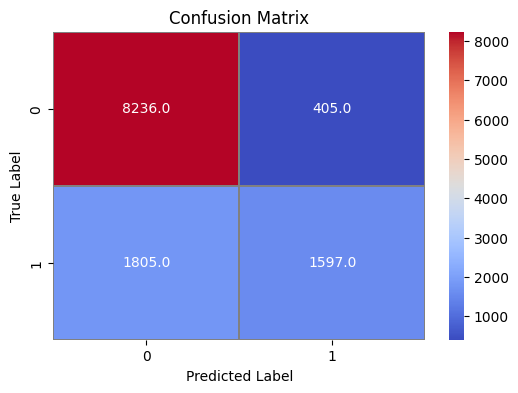

In [17]:
# Predicted Values
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Confusion matrix 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Confusion matrix visualization
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="coolwarm", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
model.evaluate(X_test,Y_test)

377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8164 - loss: 0.4874


[0.48866334557533264, 0.816490888595581]

<h2 style="color:#DE3163">Testing</h2>

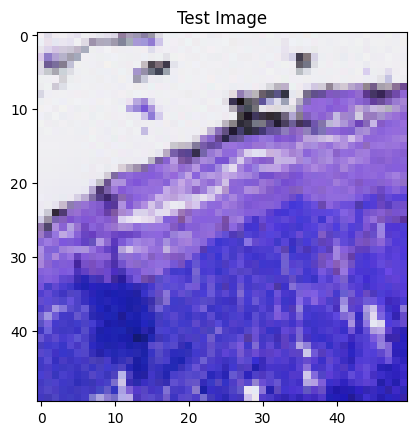

In [19]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
    
index = 1
img_plot(X_test, index)

In [20]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
index = 1
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
Predicted Value using  cnn model 0
True Value 0


<h2 style="color:#DE3163">Conclusion</h2>

The application of deep learning methods is a challenging task from understanding the dataset to preparing and modelling it. In this notebook, the stages of this challenging tasks were carried out using the Breast Histopathology Images dataset. The dataset was first visualized and positive and negative patches were categorized. Subsequently, the under-sampling method was used to solve the imbalanced class problem. Finally, a complicated model was built based on the CNN method, the training of the model was completed and the model was tested. Although the results obtained are successful, different results may be obtained in the future with different deep learning models or hybrid models, different parameter values, different epoch numbers for the same dataset. 